<a href="https://colab.research.google.com/github/MarcelahCaetanoh/Projeto-6--Classifica-o-de-Imagens/blob/main/Projeto_6_JDS_Classifica%C3%A7%C3%A3o_de_imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Projeto 6- Classificação de  Imagens - Py Torch e Transfer Learning**

***MOTIVAÇÃO***

As redes pré-treinadas existem por aí, por que não usá-las??? Muitas aplicações para problemas reais podem ser rapidamente criadas utilizando um conjunto reduzido de observações para treinamento dos modelos. Sem essa ferramenta, são necessárias dezenas de milhares de imagens para treinar uma rede do zero, ou seja, não faz sentido na grande maioria dos casos.


Uma rede convolucional é complexa nos seus meandros e detalhes debaixo do capô. Mas não é por isso que não podemos utilizar das bibliotecas que nos auxiliam na abstração de tantos detalhes para criar valor nas empresas e organizações para as quais trabalhamos ou mesmo para mostrar a capacidade de utilizar ferramentas de deep learning para solução de possíveis problemas reais (e enriquecer o portfólio)



***OBJETO DE ESTUDO***

Você foi contratado pela Let's Veggie e precisamos de um produto mínimo viável que possa ser testado nas filiais da empresa. O problema a ser solucionado é a dificuldade em classificar os produtos das lojas, pois a empresa está crescendo muito e a contratação de vendedores novatos está a mil! Muitos deles não sabem diferenciar os vegetais e frutas e uma aplicação que faça essa classificação pode ajudar bastante na expansão da companhia.

Vamos começar com a classificação de batatas, cenouras, tomates e limões! Se funcionar no celular do chefe, tenho certeza que seu valor vai subir nas alturas!








**CRIAÇÃO E SEPARAÇÃO DE BASES**

Com as imagens baixadas do google images (a gente usa o Bulk Image Downloader, mas use o que achar melhor!) podemos separá-las em treino, validação e teste.


In [88]:
from matplotlib import pyplot as plt
import numpy as np
import os
import PIL.Image

import time
import torch, torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim



In [2]:
import pandas as pd
from google.colab import drive

drive.mount ('/content/drive')

Mounted at /content/drive


In [3]:
diretorio_base_imagens = '/content/drive/My Drive/Colab Notebooks/data/raw'
pastas_com_nomes_de_vegetais = os.listdir('/content/drive/My Drive/Colab Notebooks/data/raw')
pastas_com_nomes_de_vegetais

['tomate', 'batata', 'cenoura', 'limao']

In [4]:
# Vamos criar uma separação estratificada

quantidade_por_label = {pasta: len(os.listdir(os.path.join(diretorio_base_imagens, pasta))) for pasta in pastas_com_nomes_de_vegetais}
quantidade_por_label

{'tomate': 107, 'batata': 146, 'cenoura': 181, 'limao': 111}

In [5]:
# Criando as pastas de Treino, validação e testes 

diretorio_imagens_processadas = '/content/drive/My Drive/Colab Notebooks/data/processed'

dir_treino = os.path.join(diretorio_imagens_processadas, 'treino')
dir_validacao = os.path.join(diretorio_imagens_processadas, 'validacao')
dir_teste = os.path.join(diretorio_imagens_processadas, 'teste')
 
if not os.path.exists(dir_treino):
       os.makedirs(dir_treino)

if not os.path.exists(dir_validacao):   
       os.makedirs(dir_validacao)
  
if not os.path.exists(dir_teste):
        os.makedirs(dir_teste)
 

In [6]:
import shutil
from sklearn.model_selection import train_test_split

# Criando uma pasta para  cada classe (batata, cenoura, Limao, tomate)
#dentro de treino validação e teste

for classe in pastas_com_nomes_de_vegetais: 
    dir_classe_treino = os.path.join(dir_treino, classe)
    dir_classe_validacao = os.path.join(dir_validacao, classe)
    dir_classe_teste = os.path.join(dir_teste, classe)

    if not os.path.exists(dir_classe_treino):
        os.makedirs(dir_classe_treino)  

    if not os.path.exists(dir_classe_validacao):
       os.makedirs(dir_classe_validacao)

    if not os.path.exists(dir_classe_teste):
       os.makedirs(dir_classe_teste)

# caminho completo para a pasta de imagens originais 
    pasta_classe = os.path.join(diretorio_base_imagens, classe)

# listando todos os arquivos de imagem para essa classe
    arquivos_classe = os.listdir(pasta_classe)

# separando 80% para treino e 20% para validação+teste
    treino, valid_teste = train_test_split(arquivos_classe,shuffle=True, test_size=0.2, random_state=42)
   
# separando os 20% da validação+teste em 10% para validação e 10% para teste
    validacao, teste = train_test_split(valid_teste, shuffle=True, test_size=0.5, random_state=42)

#não precisamos mais dessa lista temporária
    del valid_teste
    
    print(f'{classe} - treino: {len(treino)} - valid: {len(validacao)} - teste: {len(teste)} - total: {len(arquivos_classe)}')

# Copiando os arquivos efetivamente para as pastas de treino, validação e teste

for imagem_treino in treino:
     caminho_origem = os.path.join(diretorio_base_imagens, classe, imagem_treino)
     caminho_destino = os.path.join(dir_classe_treino, imagem_treino)

     shutil.copy(caminho_origem, caminho_destino)

for imagem_validacao in validacao:
     caminho_origem = os.path.join(diretorio_base_imagens, classe, imagem_validacao)
     caminho_destino = os.path.join(dir_classe_validacao, imagem_validacao)
   
     shutil.copy(caminho_origem, caminho_destino)

for imagem_teste in teste:
    caminho_origem = os.path.join(diretorio_base_imagens, classe, imagem_teste)
    caminho_destino = os.path.join(dir_classe_teste, imagem_teste)
 
    shutil.copy(caminho_origem, caminho_destino)        

tomate - treino: 85 - valid: 11 - teste: 11 - total: 107
batata - treino: 116 - valid: 15 - teste: 15 - total: 146
cenoura - treino: 144 - valid: 18 - teste: 19 - total: 181
limao - treino: 88 - valid: 11 - teste: 12 - total: 111


In [7]:
# Setando o tamanho da imagem
image_size = 100

# Transformando as imagens: para modelos mais robustos tem que caprichar no data augmentation
# Nesse caso não fizemos nada além do redimensionamento da imagem, mas é sempre bom fazer rotações
# espelhamentos, crop randomicos pra garantir

transformacoes_de_imagens = { 
    'treino': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ]),
    'validacao': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ]),
    'teste': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
   ])
}

In [8]:
# carregar imagens
# Determinar as pastas de treino, validação e teste

pasta_treino = dir_treino
pasta_validacao = dir_validacao
pasta_teste = dir_teste
 
pasta_treino, pasta_validacao, pasta_teste

('/content/drive/My Drive/Colab Notebooks/data/processed/treino',
 '/content/drive/My Drive/Colab Notebooks/data/processed/validacao',
 '/content/drive/My Drive/Colab Notebooks/data/processed/teste')

**Preparação para o treinamento**

Vamos definir informações importantes para o treinamento do modelo. Tamanho do batch, número de classes, datasets, data loaders, otimizadores.

In [9]:
# Tamanho do batch de treinamento
tamanho_do_batch = 8

# Determinando o número de classes (verduras/frutas)

numero_de_classes = len(os.listdir(pasta_treino))

numero_de_classes

4

In [10]:
# Carregar as imagens usando o datasets do torchvision
data = {
     'treino': datasets.ImageFolder(root=pasta_treino, transform=transformacoes_de_imagens['treino']),
      'validacao': datasets.ImageFolder(root=pasta_validacao, transform=transformacoes_de_imagens['validacao'])
}

In [11]:
data

{'treino': Dataset ImageFolder
     Number of datapoints: 448
     Root location: /content/drive/My Drive/Colab Notebooks/data/processed/treino
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ), 'validacao': Dataset ImageFolder
     Number of datapoints: 64
     Root location: /content/drive/My Drive/Colab Notebooks/data/processed/validacao
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            )}

In [12]:
# Mapear os índices com os nomes das classes (cada índice vai ter um nome de hortifruti relacionado)

indice_para_classe = {indice: classe for classe, indice in data['treino'].class_to_idx.items()}

indice_para_classe


{0: 'batata', 1: 'cenoura', 2: 'limao', 3: 'tomate'}

In [13]:
# Quantidade de imagens para serem utilizados para calcular erro médio e acurácia

num_imagens_treino = len(data['treino'])
num_imagens_validacao = len(data['validacao'])

num_imagens_treino, num_imagens_validacao

(448, 64)

In [14]:
# Cria os DataLoaders para treino e validação
# O DataLoader organiza os dados de treinamento e validação para o treinamento da rede neura
data_loader_treino = DataLoader(data['treino'], batch_size=tamanho_do_batch, shuffle=True)
data_loader_validacao = DataLoader(data['validacao'], batch_size=tamanho_do_batch, shuffle=True)


Vamos visualizar algumas imagens da base de treino para cada uma das classes

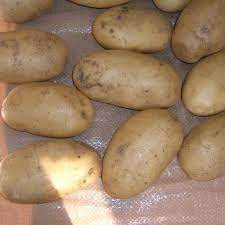

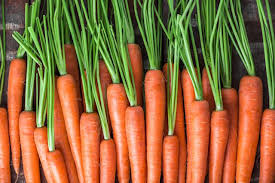

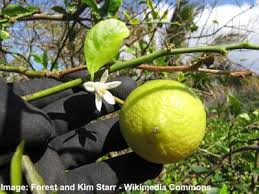

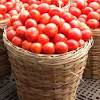

In [15]:
from IPython.display import Image

# Mostrar algumas imagens

for classe in indice_para_classe.values():
    pasta_classe = os.path.join(pasta_treino, classe)
    arquivo_imagem = os.listdir(pasta_classe)[1]
    img = Image(filename=os.path.join(pasta_classe, arquivo_imagem))
    display(img)


**Transfer Learning**

Não fosse a mágica de reaproveitar uma rede já pré-treinada, sem chances de ter um modelo bom com poucas imagens como estamos criando nesse projeto. A Alexnet é famos por ter ganhado o prêmio de melhor classificador do banco Imagenet, concurso promovido por nossa musa da IA contemporânea Fei-fei Li

---



In [16]:
# Vamos carregar nossa linda e maravilhosa Alexnet, prontinha com milhões de imagens
# treinadas

alexnet = models.alexnet(pretrained=True)

# Dar uma \"cheirada\" e analisada na estrutura da rede Alexnet

alexnet




/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [17]:
# Congelar os parametros da rede pré-treinada
# Lembrando que o required_grad = False desliga o treinamento e atualização
# dos pesos (coeficientes) das camadas da rede neural

for param in alexnet.parameters():
    param.requires_grad = False

    

In [18]:
# Mudar a última camada para alterar o número de classes
#Lembrando que aproveitamos a rede inteira, só plugamos uma camada final
# que efetivamente vai aprender as nossas classes (hortifruti)

# Alterando de Linear(in_features=4096, out_features=1000, bias=True)
# para Linear(in_features=4096, out_features=4, bias=True), pois temos 4 hortifruti
alexnet.classifier[6] = nn.Linear(4096, numero_de_classes)

# Incluindo softmax, que faz com que as probabilidades de ser cenoura, batata,
# limão ou tomate seja 1 (converte efetivamente em probabilidades para facilitar nossa análise)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))

alexnet






AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [19]:
# Perceba que a última camada é criada já com requires_grad = True
# ou seja, queremos efetivamente que ela seja treinada

parametros_ultima_camada = alexnet.classifier[6].parameters()

[parametro for parametro in parametros_ultima_camada][0].requires_grad

True

In [20]:
# Vamos utilizar a função de erro de entropia cruzada
# bastante comum para problemas de classificação
funcao_erro = nn.CrossEntropyLoss()

**Otimizador**

O Otimizador é quem efetivamente muda os pesos da rede de acordo com algum algoritmo

Nesse caso vamos utilizar o Adam Optimizer, mas poderíamos utilizar o Stochastic Gradient Descent, por exemplo

In [21]:
otimizador = optim.Adam(alexnet.parameters())
otimizador

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

**Treinar e Validar**

O treinamento realiza vários caminhos para frente (forward: previsão), cálculos de erro (distância entre previsão e valor real) e backward (backpropagation: aprendizado com o erro). A cada época, todas as imagens do treino são utilizadas para otimizar os parâmetros da rede. Dentro de cada época, utilizamos o treinamento em batch, ao invés de realizar o treinamento imagem por imagem.

Na validação, lembrar que não queremos manter o cálculo de gradientes, pois não vamos realizar o backpropagation


In [72]:

def treinar_e_validar(modelo, metrica_erro, otimizador, epocas=10):

#inicializando historico a melhor acuracia de validação melhor modelo de acordo com a validação
    historico = []
    melhor_acuracia = 0.0
    melhor_modelo = None

# Se você for rico e tiver uma RTX 3090 ti (que sonho!!)
# Mas se não for, sem problemas, sua CPU provavelmente vai dar conta do recado!
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print(device)

# Cada época perpassa todas as imagens do treino e calcula erros de treino e validação
# para aprendizado da rede neural


    for epoca in range(epocas):
        inicio_epoca = time.time()
        print("\n\nÉpoca: {}/{}".format(epoca+1, epocas))

    # Erro e acurácia de treino nessa época
        erro_treino = 0.0
        acertos_treino = 0.0
      # Erro e acurácia de validação nessa época
        erro_validacao = 0.0
        acertos_validacao = 0.0

        for i, (imagens_lote, y_reais) in enumerate(data_loader_treino):
            print(f"\nLote: {i+1}\n")

            imagens_lote = imagens_lote.to(device)
            y_reais = y_reais.to(device)

            otimizador.zero_grad()

            previsoes = modelo(imagens_lote)

            

            erro = metrica_erro(previsoes, y_reais)


            erro.backward()


            otimizador.step()


            erro_treino += erro.item() * imagens_lote.size(0)

               # Cálculo da acurácia,
               # Pra calcular a acurácia temos que buscar as classes preditas para cada imagem no lote
               # Cada tensor é uma imagem do lote com três posições: probabilidades de cada classe
               # torch.max vai retornar o valor da maior probabilidade, 
               # bem como a posição no tensor (tupla de saída)
               # A posição, portanto, vai indicar a classe com maior probabilidade (0,1,2 e 3)
               # 1o busca o valor máximo de cada tensor de cada imagem, que vai dar 
               # a classe final predita

            _, classes_previstas = torch.max(previsoes.data, 1)
            predicoes_corretas = (classes_previstas == y_reais).type(torch.FloatTensor)


            acertos = torch.mean(predicoes_corretas)

            acertos_treino += torch.sum(predicoes_corretas)

        with torch.no_grad():

               #Mudando do treinao para validação
             modelo.eval() 


                #Iteração de Validação
             for j, (imagens_lote, y_reais) in enumerate(data_loader_validacao):
                 imagens_lote = imagens_lote.to(device)
                 y_reais = y_reais.to(device)

                    #foward Pass de Validação.
                 previsoes = modelo(imagens_lote)

                   # calcular erro de Validação
                 erro = metrica_erro(previsoes, y_reais)

                   # Calcular erro de validação e adicionar a valid_loss
                 erro_validacao += erro.item() * imagens_lote.size(0)

                    # Calcular a acurácia de validação
                 _, classes_previstas = torch.max(previsoes.data, 1)
                 predicoes_corretas = (classes_previstas == y_reais).type(torch.FloatTensor)

                   # Converter os acertos para float e calcular a acurácia média
                 acertos = torch.mean(predicoes_corretas)

                   # Calcular a acurácia total de validação do lote todo e adicionar a em train_acc\
                 acertos_validacao += torch.sum(predicoes_corretas)

                   #print(\"Validação - Lote número: {:03d}, Erro: {:.4f}, Acurácia: {:.4f}\".format(j, erro.item(), acuracia.item()))

        
        #break
        # Calcular a média de erro e acurácia no treino
                 erro_medio_treino = erro_treino/num_imagens_treino
                 acuracia_media_treino = acertos_treino/num_imagens_treino

        # Calcular a média de erro e acurácia na validação
                 erro_medio_validacao = erro_validacao/num_imagens_validacao
                 acuracia_media_validacao = acertos_validacao/num_imagens_validacao

         # Incluir no histórico os erros e acurácias méidas
                 historico.append([erro_medio_treino, erro_medio_validacao, acuracia_media_treino, acuracia_media_validacao])
        
                 fim_epoca = time.time()
        
                 print("Época : {:03d}, Treino: Erro: {:.4f}, Acurácia: {:.4f}%, \n\t\tValidação : Erro : {:.4f}, Acurácia: {:.4f}%, Tempo: {:.4f}s".format(epoca+1, erro_medio_treino, acuracia_media_treino*100, erro_medio_validacao, acuracia_media_validacao*100, fim_epoca-inicio_epoca))

        # Testa se a acurácia na validação desse modelo nessa época é a melhor
        # Se for a melhor, salva no melhor modelo e na melhor acurácia
                 if acuracia_media_validacao > melhor_acuracia:
                     melhor_acuracia = acuracia_media_validacao
           #torch.save(modelo, './modelos/melhor_modelo.pt')
                     melhor_modelo = modelo

             return melhor_modelo, historico


                          

In [67]:
indice_para_classe

{0: 'batata', 1: 'cenoura', 2: 'limao', 3: 'tomate'}

In [73]:
numero_de_epocas = 10

modelo_treinado, historico = treinar_e_validar(alexnet, funcao_erro, otimizador, numero_de_epocas)

cpu


Época: 1/10

Lote: 1


Lote: 2


Lote: 3


Lote: 4


Lote: 5


Lote: 6


Lote: 7


Lote: 8


Lote: 9


Lote: 10


Lote: 11


Lote: 12


Lote: 13


Lote: 14


Lote: 15


Lote: 16


Lote: 17


Lote: 18


Lote: 19


Lote: 20


Lote: 21


Lote: 22


Lote: 23


Lote: 24


Lote: 25


Lote: 26


Lote: 27


Lote: 28


Lote: 29


Lote: 30


Lote: 31


Lote: 32


Lote: 33


Lote: 34


Lote: 35


Lote: 36


Lote: 37


Lote: 38


Lote: 39


Lote: 40


Lote: 41


Lote: 42


Lote: 43


Lote: 44


Lote: 45


Lote: 46


Lote: 47


Lote: 48


Lote: 49


Lote: 50


Lote: 51


Lote: 52


Lote: 53


Lote: 54


Lote: 55


Lote: 56

Época : 001, Treino: Erro: 0.0011, Acurácia: 100.0000%, 
		Validação : Erro : 0.0002, Acurácia: 12.5000%, Tempo: 7.0326s
Época : 001, Treino: Erro: 0.0011, Acurácia: 100.0000%, 
		Validação : Erro : 0.0003, Acurácia: 25.0000%, Tempo: 7.1567s
Época : 001, Treino: Erro: 0.0011, Acurácia: 100.0000%, 
		Validação : Erro : 0.0023, Acurácia: 37.5000%, Tempo: 7.2788s
Época : 001,

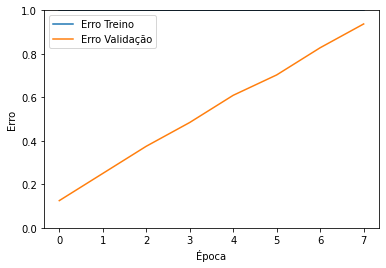

In [75]:
historico = np.array(historico)

plt.plot(historico[:,2:])
plt.legend(['Erro Treino', 'Erro Validação'])
plt.xlabel('Época')
plt.ylabel('Erro')
plt.ylim(0,1)
plt.show()

Vamos criar a função para prever a classe de uma imagem com o melhor modelo treinado. É bem parecido com o que fazemos na validação, um \"forward pass\" na rede, sem atualizar os gradientes ou os parâmetros da rede.

In [81]:
def predicao_lets_veggie(imagem_teste):

     transformacao = transformacoes_de_imagens['teste']
     tensor_imagem_teste = transformacao(imagem_teste)

     if torch.cuda.is_available():
         tensor_imagem_teste = tensor_imagem_teste.view(1, 3, image_size, image_size).cuda()
     else:
         tensor_imagem_teste = tensor_imagem_teste.view(1, 3, image_size, image_size)
                                                        
     dict_predicoes = dict()

     # Não precisa calcular os gradientes com o autograd

     with torch.no_grad():
         modelo_treinado.eval()
         predicoes_log = modelo_treinado(tensor_imagem_teste)
         predicoes = torch.exp(predicoes_log)
         dict_predicoes = {indice_para_classe[classe]: float(predicoes[0][classe]) for classe in range(numero_de_classes)}
     return dict_predicoes

**Previsão em imagens de teste**

Não utilizamos as imagens de teste em nenhum lugar! Assim que aprendemos que deve ser e faremos para todo o sempre como bons e boas cientistas de dados

Vamos fazer algumas previsões só para \"brincar\" e depois calculamos a acurácia


'tomate'

'batata'

'cenoura'

'limao'

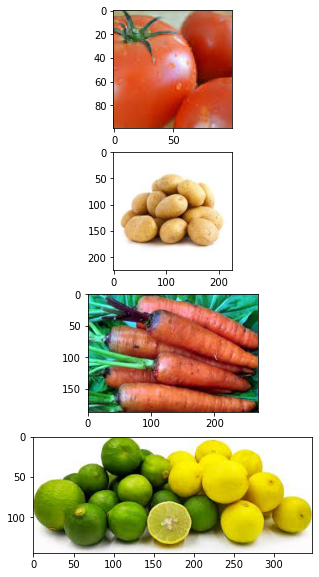

In [82]:
figura, plots = plt.subplots(nrows=numero_de_classes, ncols=1, figsize=(5, 10))
for indice, classe in enumerate(pastas_com_nomes_de_vegetais):
    pasta_teste_classe = os.path.join(pasta_teste, classe)
    imagem = os.path.join(pasta_teste_classe, os.listdir(pasta_teste_classe)[2])
    imagem_teste = PIL.Image.open(imagem)

    plots[indice].imshow(imagem_teste)

    predicoes = predicao_lets_veggie(imagem_teste)

    display(max(predicoes, key=predicoes.get))


In [83]:
def acuracia_teste(pasta_teste):
    acertos = 0
    total_imagens = 0

    for classe in os.listdir(pasta_teste):
        pasta_completa = os.path.join(pasta_teste, classe)
        total_imagens += len(os.listdir(pasta_completa))    

        for imagem in os.listdir(pasta_completa):
            imagem = os.path.join(pasta_completa, imagem)
            imagem_teste = PIL.Image.open(imagem)
            predicoes = predicao_lets_veggie(imagem_teste)
            predicao = max(predicoes, key=predicoes.get)

            if predicao == classe:
               acertos += 1


    return 100 * acertos/total_imagens         


In [84]:
acuracia_teste(pasta_teste)

97.01492537313433

**Deploy do Modelo**
Vamos fazer uma aplicação simples usando o maravilhoso Gradio!


In [91]:
pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.8 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 270 kB 46.0 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 212 kB 64.3 MB/s 
     |████████████████████████████████| 112 kB 62.7 MB/s 
     |████████████████████████████████| 56 kB 4.2 MB/s 
     |████████████████████████████████| 2.3 MB 30.2 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 80 kB 9.2 MB/s 
     |████████████████████████████████| 68 kB 6.2 MB/s 
     |████████████████████████████████| 46 kB 3.2 MB/s 
     |████████████████████████████████| 593 kB 50.4 MB/s 
     |████████████████████████████████| 856 kB 47.

In [92]:
import gradio as gr

interface_gradio = gr.Interface(fn=predicao_lets_veggie,
                                 inputs=gr.inputs.Image(type="pil"),
                                 outputs="label").launch(share=True)


/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://19e63680e12418b0.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
